# <span style="color:blue">EVAC Workshop 1: Introduction to GAs in DEAP</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the pre-wrokshop materials:
- Lectures 1, 2a and 2b
- Code walkthroughs 1 and 2

# Colab Packages Install

In [1]:
!pip3 install deap
!pip3 install matplotlib


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


## <span style="color:#0073e6">Learning objectives</span>

- To gain familiarity with the DEAP toolbox for Python
- To understand how to code a simple GA
- To understand crossover, selection, representation, and fitness functions
- To appreciate how algorithm parameterization can affect performance

# <span style="color:blue">Practical Instructions</span>

Below is a max-ones problem implementation (mentioned in the walkthrough) along with a simple GA solution in DEAP. Run the problem and examine the results. Then follow the exercises that follow the code.

# <span style="color:blue">Max Ones implementation</span>

In [2]:
import random
import numpy
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools

In [3]:
"""This code sets up the basic framework for running a genetic algorithm to solve the OneMax problem, where the goal is to evolve a binary string (individual) with all 1s. 
The fitness of an individual is simply the count of 1s in the string. */"""


# This line creates a new class named "FitnessMax" using the creator module. It inherits from base.Fitness class, and weights=(1.0,) indicates that this is a single-objective fitness class with a weight of 1.0.
creator.create( "FitnessMax", base.Fitness, weights=(1.0,))


#creator.create("Individual", list, fitness=creator.FitnessMax): This line creates another class named "Individual", which is a Python list (array) with a fitness attribute of type "FitnessMax".
creator.create("Individual", list, fitness=creator.FitnessMax)

# Creates a toolbox, which is essentially a container for registering functions used in the evolutionary algorithm.
toolbox = base.Toolbox()

# Registers a function named "attr_bool" that generates random integers (0 or 1). This function will be used to initialize genes in an individual.
toolbox.register("attr_bool", random.randint, 0, 1)

# Registers a function to create an individual. It uses tools.initRepeat to initialize an individual with 100 genes, each generated by the "attr_bool" function.
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)

# Registers a function to create a population. It uses tools.initRepeat to initialize a population as a list of individuals, each generated by the "individual" function.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    """Takes an individual as input and returns a tuple containing the sum of all the genes in the individual."""
    return (sum(individual),)

# Registers the evaluation function.
toolbox.register("evaluate", evalOneMax)

# Registers a selection operator using tournament selection with a tournament size of 3.
toolbox.register("select", tools.selTournament, tournsize=3)

# Registers a crossover operator using a two-point crossover.
toolbox.register("mate", tools.cxTwoPoint)

# Registers a mutation operator using bit-flip mutation with a probability of 0.01.
toolbox.register("mutate", tools.mutFlipBit, indpb=0.01) #inpb Mutation Probability

In [4]:
"""These components are useful for tracking and analyzing the progress of the evolutionary algorithm. The logbook can be used to record various data throughout the evolutionary process, such as the generation number and the best individual found. The statistics object allows for the calculation and storage of statistical measures (e.g., mean, standard deviation, min, max) of the population's fitness values at each generation. This information can be used to analyze the performance and convergence of the algorithm."""

# Creates a logbook object, which is a data structure used to store and organize data, typically for logging the progress of an evolutionary algorithm.
logbook = tools.Logbook()

# Creates a statistics object to collect statistics on the population during the evolution process.
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

# Registers the mean function from NumPy to calculate the average fitness of the population.
stats.register("avg", numpy.mean)

# Registers the std function from NumPy to calculate the standard deviation of the fitness values in the population.
stats.register("std", numpy.std)

# Registers the min function from NumPy to calculate the minimum fitness value in the population.
stats.register("min", numpy.min)

# Registers the max function from NumPy to calculate the maximum fitness value in the population.
stats.register("max", numpy.max)

In [5]:
"""This block of code sets up the initial population for the evolutionary algorithm by creating a list of individuals and evaluating their fitness values based on the problem definition. Then, it assigns these fitness values to the individuals' fitness attributes for further processing during the evolutionary algorithm."""

# Creates a population of 100 individuals using the toolbox.population function that was previously registered. This function creates a list of individuals, where each individual is created using the toolbox.individual function.
pop = toolbox.population(n=100)

# Evaluates the fitness of each individual in the population using the toolbox.evaluate function that was registered earlier. This line uses the map function to apply the toolbox.evaluate function to each individual in the population pop, and then converts the result into a list.
fitnesses = list(map(toolbox.evaluate, pop))

# Iterates through each individual ind in the population pop and its corresponding fitness value fit.
for ind, fit in zip(pop, fitnesses):
    # Assigns the fitness value fit to the fitness.values attribute of the individual ind.
    ind.fitness.values = fit

In [6]:
"""This loop represents the core of the evolutionary algorithm, where selection, crossover, mutation, evaluation, and population replacement are performed iteratively over multiple generations. The process continues until the specified number of generations (NGEN) is reached. Throughout the loop, statistics are recorded in the logbook to monitor the progress of the evolutionary algorithm."""

# Defines the total number of generations.
NGEN = 100
for g in range(NGEN):
    print("-- Generation %i --" % g)

    # Selects individuals from the current population pop using the selection operator registered in the toolbox.
    offspring = toolbox.select(pop, len(pop))
    
    # Clones the selected individuals to create offspring for the next generation.
    offspring = list(map(toolbox.clone, offspring))

    # Crossover and Mutation
    # Iterates over pairs of offspring to perform crossover and mutation.
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        # Applies crossover (mating) to generate children from pairs of offspring.
        toolbox.mate(child1, child2)
        
        # Deletes the fitness values of the children because they are no longer valid after crossover.
        del child1.fitness.values
        del child2.fitness.values
    
    # Mutation - iterates over each offspring to apply mutation.
    for mutant in offspring:
        # Applies mutation to each offspring.
        toolbox.mutate(mutant)
        # Deletes the fitness values of the mutant because they are no longer valid after mutation.
        del mutant.fitness.values
    
    # Evaluation
    # Identifies individuals in the offspring whose fitness values are not valid.
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    
    # Evaluates the fitness of invalid individuals.
    fitnesses = map(toolbox.evaluate, invalid_ind)
    
    # Assigns the fitness values to the evaluated individuals.
    for ind, fit in zip(invalid_ind, fitnesses):
        # Assigns the fitness value fit to the fitness.values attribute of the individual ind.
         ind.fitness.values = fit

    # Updating Population:
    # Replaces the current population with the offspring generated in this generation.
    pop[:] = offspring
    
    # Recording Statistics
    
    # Computes statistics for the current population.
    record = stats.compile(pop)
    
    # Records the statistics for the current generation g in the logbook. The **record syntax unpacks the dictionary record and passes its contents as keyword arguments to the logbook.record function.
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [7]:
"""Used for plotting or further analysis. For example, gen will contain the generation numbers, avgs will contain the corresponding average fitness values, and stds will contain the corresponding standard deviations of fitness values. These data can be plotted to visualize the evolution of the population's fitness over generations."""

# Sets the header of the logbook to indicate the columns. The columns are "gen" for generation number, "avg" for average fitness, "std" for standard deviation of fitness, "min" for minimum fitness, and "max" for maximum fitness.
logbook.header = "gen", "avg", "std", "min", "max"

# Selects the data from the logbook for the "gen" column (generation number).
gen = logbook.select("gen")

# Selects the data from the logbook for the "avg" column (average fitness).
avgs = logbook.select("avg")

# Selects the data from the logbook for the "std" column (standard deviation of fitness).
stds = logbook.select("std")

Text(0, 0.5, 'Mean Fitness')

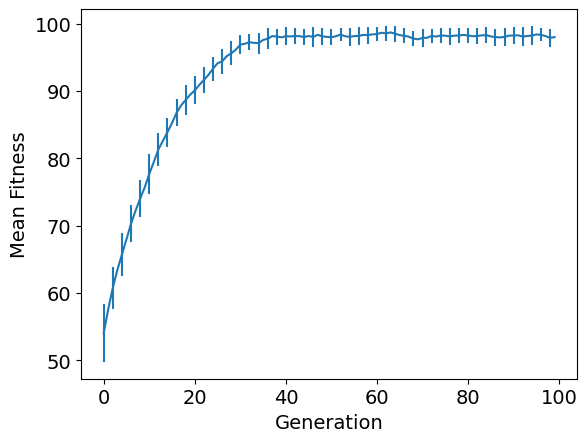

In [8]:
"""This code segment sets up the plot to visualize how the mean fitness of the population evolves across generations, with error bars indicating the variability in fitness values."""

# These lines set the default font sizes for various elements of the plot, such as axes labels, tick labels, and legend font size.
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

# Creates a figure and a set of subplots (in this case, only one subplot). ax1 is the Axes object used for plotting.
fig, ax1 = plt.subplots()
#line1 = ax1.plot(gen, avgs)

# Plots the mean fitness values (avgs) across generations (gen). Error bars are added to show the standard deviation (stds) of fitness values. The errorevery=2 parameter indicates that error bars will be plotted for every 2nd data point, for better visibility.
line1 = ax1.errorbar(gen, avgs, yerr=stds, errorevery=2)

# Sets the label for the x-axis to "Generation".
ax1.set_xlabel("Generation")

# Sets the label for the y-axis to "Mean Fitness".
ax1.set_ylabel("Mean Fitness")

In [9]:
print(logbook)

gen	avg  	std     	min	max
0  	54.03	4.29291 	42 	65 
1  	57.58	3.96782 	47 	65 
2  	60.74	3.07122 	53 	69 
3  	63.41	2.92265 	53 	72 
4  	65.69	3.17394 	58 	73 
5  	67.97	2.75846 	58 	74 
6  	70.28	2.79313 	64 	77 
7  	72.24	2.7897  	66 	80 
8  	73.99	2.76585 	68 	82 
9  	75.68	3.07857 	68 	84 
10 	77.65	2.95762 	70 	84 
11 	79.47	2.74756 	71 	86 
12 	81.31	2.47667 	75 	91 
13 	82.6 	2.30217 	78 	88 
14 	83.89	2.15822 	79 	89 
15 	85.24	2.4336  	79 	91 
16 	86.76	2.03037 	81 	91 
17 	87.86	2.02    	83 	92 
18 	88.68	2.1949  	81 	94 
19 	89.46	1.79677 	84 	93 
20 	90.1 	2.08567 	85 	95 
21 	90.91	2.01045 	84 	96 
22 	91.66	1.95049 	87 	97 
23 	92.4 	1.84932 	89 	97 
24 	93.32	1.81041 	89 	98 
25 	94.13	1.87433 	90 	98 
26 	94.4 	1.83848 	89 	99 
27 	95.18	1.61481 	91 	99 
28 	95.6 	1.77764 	90 	99 
29 	96.14	1.7494  	92 	100
30 	96.89	1.41347 	92 	100
31 	97.03	1.29965 	94 	99 
32 	97.26	1.22164 	93 	100
33 	97.16	1.12889 	95 	100
34 	97.11	1.55496 	92 	100
35 	97.59	1.4906  	93 	100
3

# <span style="color:blue">Exercise 1: Getting to know the GA</span>

- Try playing with the crossover and mutation probabilities. Can you tweak these parameters to improve performance? Why does the performance improve / not improve / get worse?

- Change the line that creates the fitness class, change weights=(1.0,) to weights=(-1.0,)). This changes the problem from a maximization problem to a minimization problem. What effect does this have?

- This code currently using two-point crossover to combine the genomes of selected parents to produce offspring. This produces offspring by selecting two random positions on the genome, and swapping values between these two positions. Uniform crossover randomly swaps values at each location in the genome with a given probability. Let’s begin customizing our algorithm using uniform crossover instead. Find the definition of the crossover operator, which has been registered in the toolbox as the function ‘mate’. Now change the operator (you can use the Library Reference to find the built-in command for this). Run the program.

You might see the following error:  

``TypeError: cxUniform() takes exactly 3 arguments (2 given)``  

A quick look at the documentation for the cxUniform function will show you that this is because the new crossover function takes an extra argument: the probability of a swap at each position (locus) in the genome. Find the part of the code where mating occurs and pass the toolbox.mate command the extra parameter value (say 0.1). Alternatively, you can define the comment when you register cxUnifrom as “mate”. Now your code will run.


# <span style="color:blue">Exercise 2: Implement a Real Valued Version</span>

Modify the code so that instead of counting binary 1s, the problem is to maximize the total value of genes whose values are real numbers between 0 and 1, inclusive. For example [0.5, 0.2, 0.1, 0.3] would give a fitness value of 1.1.

# <span style="color:blue">Exercise 3: Write your own operator</span>

Let’s write our own mutation operator and register it in the toolbox.  Implement a uniform operator for the real valued version that replaces each value in the genome with a random uniform number between 0 and 1 using a fixed mutation probability per gene, or that adds a float number to the gene.
To do this, you need to write your own Python function that takes in an individual, and anything else you need (e.g. probability of mutation per gene) and modifies the individual. The function should return a tuple, with the individual as the first element  e.g. return individual,

# <span style="color:blue">Exercise 4: Change the problem to a ‘deceptive’ problem</span>

This exercise will test your understanding of the principles in this practical and teach you about the impact of choices of representation.

First, revert back to the original Max Ones code. Now modify the Max Ones problem to implement the following ‘deceptive’ problem. A deceptive problem is just a problem that has local optima in which the algorithm can become trapped. Note that the standard Max Ones problem only has a global optimum.

In this problem, the bit string should be split into six blocks of three bits, where each block is assigned a partial fitness based on the number of ones in that block. Here is an example individual:

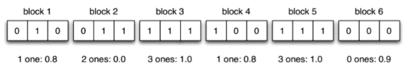

The fitness for each block of three is given as follows:
- 0 ones: partial fitness 0.9
- 1 ones: partial fitness 0.8
- 2 ones: partial fitness 0.0
- 3 ones: partial fitness 1.0

The fitness of the entire string is then determined by calculating the summed value over all blocks. For example, the individual above has a fitness of:  
``(0.8 + 0.0 + 1.0 + 0.8 + 1.0 + 0.9) = 4.5``

**Your task: Set the length of the individuals to 18 and implement this problem.**

<span style="color:green">Questions to think about:  </span>
- <span style="color:green">What is it about this fitness landscape that makes it (for some algorithms) difficult to traverse?  </span>
- <span style="color:green">What is the global optimum for this problem? What do you think the fitness landscape looks like?  </span>
- <span style="color:green">Run the algorithm multiple times. Do you get the same result each time?  </span>
- <span style="color:green">Does your algorithm find the global optimum? Why?  </span>
- <span style="color:green">Can you improve the result by changing parameters or operators?</span>

# <span style="color:blue">Exercise 5: Multiple runs</span>

Genetic algorithms are stochastic. As such, you might get a different result every time you run it; sometimes, for example, getting stuck on local optima and sometimes now. Try to modify the algorithm to run 50 times. Then record and plot a distribution of the final mean fitness scores. The matplotlib code for a density plot is:  

```plt.hist(avgRuns, density=True, bins=10)```  
(You might need to change the number of bins).

You should see that, for this problem, there's no a lot of variation. But this is unusual with harder problems.